In [4]:
# make sure this is running in the right environment!! caiman, NOT caiman_test!
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite,imread
from skimage import measure as sm

import SimpleITK as sitk
import h5py

import largestinteriorrectangle as lir
import matplotlib.patches as pac
from copy import deepcopy

from scipy import io as sio
from scipy import interpolate as si
from scipy import signal as sg
from scipy import stats as ss
from scipy import spatial as sp
from skimage import measure as sm
from skimage import metrics as sme
from skimage import transform as st
from skimage import feature as sf
from scipy.sparse import csc_matrix

from tqdm.auto import tqdm,trange
#%load_ext memory_profiler

from pathlib import Path
import pickle

import cv2
import multiprocessing
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
from caiman.source_extraction.cnmf import cnmf,params
from caiman.utils.visualization import view_quilt,get_contours
from caiman.paths import caiman_datadir

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

def load_pickle(file_path):
    """
    Load a dictionary from a pickle file.

    Args:
    - file_path (str): Path to the pickle file.

    Returns:
    - dict: Loaded dictionary.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

Loading BokehJS ...

In [5]:
#optimizing things from here - actually just stick with joblib/loky and take the L on timing - might not even be a CPU issue but data saving?
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [6]:
# first part of S1 - 50-50 vs 100% Matrigel tiling movies - remember that here only the strain matters (translation is mostly artifact)
data_dip = [r'\dipping\20230915_PL52\wells001',
            r'\dipping\20230915_PL52\wells101',
            r'\dipping\20230915_PL52\wells201',
            r'\dipping\20230915_PL52\wells301',
            r'\dipping\20230915_PL52\wells401',
            r'\dipping\20230916_PL48\wells001',
            r'\dipping\20230916_PL48\wells101',
            r'\dipping\20230916_PL54\wells001',
            r'\dipping\20230916_PL54\wells101',
            r'\dipping\20230916_PL54\wells201',
            r'\dipping\20230916_PL54\wells301',
            r'\dipping\20230916_PL54\wells401',
            r'\dipping\20230916_PL54\wells501',
            r'\dipping\20230920_PL56\wells001',
            r'\dipping\20230920_PL56\wells101',
            r'\dipping\20230920_PL56\wells201',
            r'\dipping\20230920_PL58\wells001',
            r'\dipping\20230920_PL58\wells101',
            r'\dipping\20230920_PL58\wells201',
            r'\dipping\20230920_PL58\wells301',
            r'\dipping\20230922_PL28\wells001',
            r'\dipping\20230922_PL28\wells101',
            r'\dipping\20230922_PL28\wells201',
            r'\dipping\20230922_PL28\wells301',
            r'\dipping\20230922_PL28\wells401',
            r'\dipping\20230922_PL28\wells501',
            r'\dipping\20230922_PL28\wells601',
            r'\dipping\20230922_PL28\wells701',
            r'\dipping\20230923_PL35\wells001',
            r'\dipping\20230923_PL35\wells101',
            r'\dipping\20230923_PL35\wells201',
            r'\dipping\20230923_PL35\wells301',
            r'\dipping\20230923_PL35\wells401',
            r'\dipping\20230923_PL35\wells501',
            r'\dipping\20230925_PL58\wells001',
            r'\dipping\20230925_PL58\wells101',
            r'\dipping\20230925_PL58\wells201',
            r'\dipping\20230925_PL58\wells301',
            r'\dipping\20230925_PL58\wells401',
            r'\dipping\20230926_PL56\wells001',
            r'\dipping\20230926_PL56\wells101',
            r'\dipping\20230926_PL56\wells201',
            r'\dipping\20230926_PL56\wells301',
            r'\dipping\20230926_PL56\wells401',
            r'\dipping\20230926_PL56\wells501',
            r'\dipping\20230927_PL34\wells001',
            r'\dipping\20230927_PL34\wells101',
            r'\dipping\20230927_PL34\wells201',
            r'\dipping\20230927_PL34\wells301',
            r'\dipping\20230927_PL58\wells001',
            r'\dipping\20230927_PL58\wells101',
            r'\dipping\20230927_PL58\wells201',
            r'\dipping\20230927_PL58\wells301']
ref_dip = []

data_invivo = [r'\in_vivo\231017_DG49PL70\mouse',
              r'\in_vivo\231018_DG52PL66\mouse',
              r'\in_vivo\231019_DG53PL68\mouse',
              r'\in_vivo\231024_DG54PL61\mouse',
              r'\in_vivo\231025_DG56PL62\mouse',
              r'\in_vivo\231027_DG57PL69\mouse',
              r'\in_vivo\231029_DG58PL64\mouse',
              r'\in_vivo\231030_DG60PL67\mouse',
              r'\in_vivo\231031_DG53PL28\mouse',
              r'\in_vivo\231105_DG39PL32\mouse',
              r'\in_vivo\231105_DG43PL32\mouse',
              r'\in_vivo\231106_DG52PL68\mouse',
              r'\in_vivo\231107_DG44PL58\mouse',
              r'\in_vivo\231108_DG61PL62\mouse']

ref_invivo = []

data_slice = [r'\slice\20230822_SL1PL32\slice',
             r'\slice\20230822_SL2PL52\slice',
             r'\slice\20230822_SL3PL58\slice',
             r'\slice\20230824_SL1PL60\slice',
             r'\slice\20230824_SL2PL54\slice',
             r'\slice\20230829_SL1PL56\slice',
             r'\slice\20230829_SL2PL39\slice',
             r'\slice\20230829_SL3PL61\slice',
             r'\slice\20230830_SL1PL28\slice',
             r'\slice\20230830_SL2PL60\slice',
             r'\slice\20230831_SL1PL55\slice']

ref_slice = []

timefac52 = 99.81 #number of seconds between volumes
timefac31 = 72.68 #60
scalefac = np.array([4,4,9]) #multiplicative factor to get to um distance in x,y,z, will only be different for the 10 slice movies with 561x495

headp = r'\\nasquatch\data\2p\peter'
headd = r'D:\2p_data\peter'

tailp52o = r'\segtrack\segs\ch0\52_mean__\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg\prob_movie.npy'
tailp52r = r'\segtrack\segs\ch0\52_mean_warped_\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg\prob_movie.npy'
tailp52g = r'\segtrack\segs\ch0\52_mean_warped_ch0\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg\prob_movie.npy'
tailp31o = r'\segtrack\segs\ch0\31_mean__\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg\prob_movie.npy'
tailp31r = r'\segtrack\segs\ch0\31_mean_warped_\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg\prob_movie.npy'
tailp31g = r'\segtrack\segs\ch0\31_mean_warped_ch0\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg\prob_movie.npy'

dird52g = r'\segtrack\segs\ch0\52_mean__\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg'
dird52r = r'\segtrack\segs\ch1\52_mean__\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg'
dird31g = r'\segtrack\segs\ch0\31_mean__\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg'
dird31r = r'\segtrack\segs\ch1\31_mean__\cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC\seg'

oc_dip = []
rc_dip = []
gc_dip = []
oc_invivo = []
rc_invivo = []
gc_invivo = []
oc_slice = []
rc_slice = []
gc_slice = []

In [173]:
#data_dip values - calculate alignment fraction pre-warp vs green warp vs red warp
n_cores = 30
for i in trange(len(data_dip)):
#i = 0
    refl = np.nan
    for j in range(len(os.listdir(headd+data_dip[i]+dird31g))):
        if (r'toref' in os.listdir(headd+data_dip[i]+dird31g)[j]) and (r'xydftshifts' not in os.listdir(headd+data_dip[i]+dird31g)[j]):
            refl = j
    ref_dip.append(int(os.listdir(headd+data_dip[i]+dird31g)[refl][os.listdir(headd+data_dip[i]+dird31g)[refl].find(r'toref')+5:-4]))
    
    pmo = np.load(headp+data_dip[i]+tailp31o,mmap_mode='r+')
    pmr = np.load(headp+data_dip[i]+tailp31r,mmap_mode='r+')
    pmg = np.load(headp+data_dip[i]+tailp31g,mmap_mode='r+')
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmo[0,...]*(pmo[0,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))
    
    pmocto0cref = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmr[0,...]*(pmr[0,...]>0)*(pmr[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmr.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmr[k,...]*(pmr[k,...]>0)*(pmr[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmr.shape[0]))
    
    pmrcto0cref = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmg[0,...]*(pmg[0,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))
    
    pmgcto0cref = np.asarray(results)
    del results
    
    oc_dip.append(pmocto0cref.flatten())
    rc_dip.append(pmrcto0cref.flatten())
    gc_dip.append(pmgcto0cref.flatten())

  0%|          | 0/53 [00:00<?, ?it/s]


Correlating...: 100%|██████████████████████████| 36/36 [00:14<00:00,  2.51it/s]

Correlating...: 100%|██████████████████████████| 36/36 [00:12<00:00,  2.82it/s]

Correlating...: 100%|██████████████████████████| 36/36 [00:12<00:00,  2.78it/s]

Correlating...: 100%|██████████████████████████| 30/30 [00:14<00:00,  2.12it/s]

Correlating...: 100%|██████████████████████████| 30/30 [00:14<00:00,  2.12it/s]

Correlating...: 100%|██████████████████████████| 30/30 [00:14<00:00,  2.11it/s]

Correlating...: 100%|██████████████████████████| 63/63 [00:27<00:00,  2.26it/s]

Correlating...: 100%|██████████████████████████| 63/63 [00:27<00:00,  2.29it/s]

Correlating...: 100%|██████████████████████████| 63/63 [00:28<00:00,  2.18it/s]

Correlating...: 100%|██████████████████████████| 51/51 [00:22<00:00,  2.27it/s]

Correlating...: 100%|██████████████████████████| 51/51 [00:24<00:00,  2.12it/s]

Correlating...: 100%|██████████████████████████| 51/51 [00:23<00:00,  2.21it/s]

Correlating...: 100%|██████

In [174]:
#data_invivo values - calculate alignment fraction pre-warp vs green warp vs red warp
n_cores = 30
for i in trange(len(data_invivo)):
#i = 0
    refl = np.nan
    for j in range(len(os.listdir(headd+data_invivo[i]+dird52g))):
        if (r'toref' in os.listdir(headd+data_invivo[i]+dird52g)[j]) and (r'xydftshifts' not in os.listdir(headd+data_invivo[i]+dird52g)[j]):
            refl = j
    ref_dip.append(int(os.listdir(headd+data_invivo[i]+dird52g)[refl][os.listdir(headd+data_invivo[i]+dird52g)[refl].find(r'toref')+5:-4]))
    
    pmo = np.load(headp+data_invivo[i]+tailp52o,mmap_mode='r+')
    pmr = np.load(headp+data_invivo[i]+tailp52r,mmap_mode='r+')
    pmg = np.load(headp+data_invivo[i]+tailp52g,mmap_mode='r+')
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmo[0,...]*(pmo[0,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))
    
    pmocto0cref = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmr[0,...]*(pmr[0,...]>0)*(pmr[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmr.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmr[k,...]*(pmr[k,...]>0)*(pmr[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmr.shape[0]))
    
    pmrcto0cref = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmg[0,...]*(pmg[0,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))
    
    pmgcto0cref = np.asarray(results)
    del results
    
    oc_invivo.append(pmocto0cref.flatten())
    rc_invivo.append(pmrcto0cref.flatten())
    gc_invivo.append(pmgcto0cref.flatten())

  0%|          | 0/14 [00:00<?, ?it/s]


Correlating...: 100%|████████████████████████| 143/143 [00:58<00:00,  2.43it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:08<00:00,  2.07it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:07<00:00,  2.09it/s]

Correlating...: 100%|████████████████████████| 143/143 [01:06<00:00,  2.15it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:06<00:00,  2.15it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:13<00:00,  1.94it/s]

Correlating...: 100%|████████████████████████| 170/170 [01:16<00:00,  2.23it/s]

Correlating...: 100%|████████████████████████| 169/169 [01:21<00:00,  2.07it/s]

Correlating...: 100%|████████████████████████| 169/169 [01:15<00:00,  2.23it/s]

Correlating...: 100%|████████████████████████| 143/143 [00:57<00:00,  2.49it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:01<00:00,  2.32it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:00<00:00,  2.35it/s]

Correlating...: 100%|██████

In [175]:
#data_slice values - calculate alignment fraction pre-warp vs green warp vs red warp
n_cores = 30
for i in trange(len(data_slice)):
#i = 0
    refl = np.nan
    for j in range(len(os.listdir(headd+data_slice[i]+dird52g))):
        if (r'toref' in os.listdir(headd+data_slice[i]+dird52g)[j]) and (r'xydftshifts' not in os.listdir(headd+data_slice[i]+dird52g)[j]):
            refl = j
    ref_dip.append(int(os.listdir(headd+data_slice[i]+dird52g)[refl][os.listdir(headd+data_slice[i]+dird52g)[refl].find(r'toref')+5:-4]))
    
    pmo = np.load(headp+data_slice[i]+tailp52o,mmap_mode='r+')
    pmr = np.load(headp+data_slice[i]+tailp52r,mmap_mode='r+')
    pmg = np.load(headp+data_slice[i]+tailp52g,mmap_mode='r+')
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmo[0,...]*(pmo[0,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))
    
    pmocto0cref = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmr[0,...]*(pmr[0,...]>0)*(pmr[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmr.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmr[k,...]*(pmr[k,...]>0)*(pmr[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmr.shape[0]))
    
    pmrcto0cref = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmg[0,...]*(pmg[0,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))
    
    pmgcto0cref = np.asarray(results)
    del results
    
    oc_slice.append(pmocto0cref.flatten())
    rc_slice.append(pmrcto0cref.flatten())
    gc_slice.append(pmgcto0cref.flatten())

  0%|          | 0/11 [00:00<?, ?it/s]


Correlating...: 100%|██████████████████████████| 57/57 [00:25<00:00,  2.22it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.26it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.32it/s]

Correlating...: 100%|██████████████████████████| 57/57 [00:24<00:00,  2.33it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:23<00:00,  2.33it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.28it/s]

Correlating...: 100%|██████████████████████████| 57/57 [00:24<00:00,  2.37it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:23<00:00,  2.34it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.30it/s]

Correlating...: 100%|██████████████████████████| 54/54 [00:23<00:00,  2.32it/s]

Correlating...: 100%|██████████████████████████| 53/53 [00:22<00:00,  2.35it/s]

Correlating...: 100%|██████████████████████████| 53/53 [00:22<00:00,  2.33it/s]

Correlating...: 100%|██████

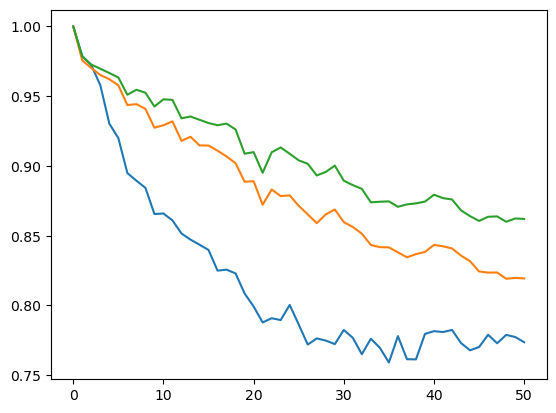

In [200]:
r = 45
plt.plot(oc_dip[r])
plt.plot(rc_dip[r])
plt.plot(gc_dip[r])

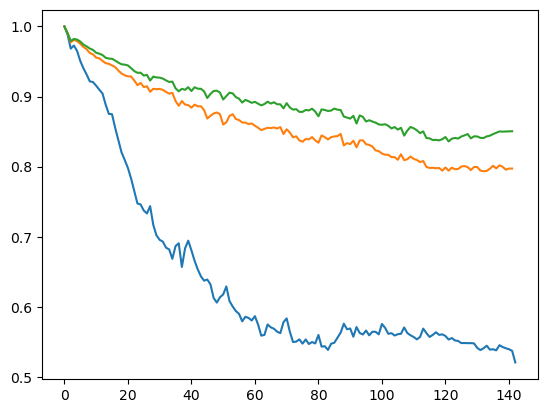

In [252]:
r = 1
plt.plot(oc_invivo[r])
plt.plot(rc_invivo[r])
plt.plot(gc_invivo[r])

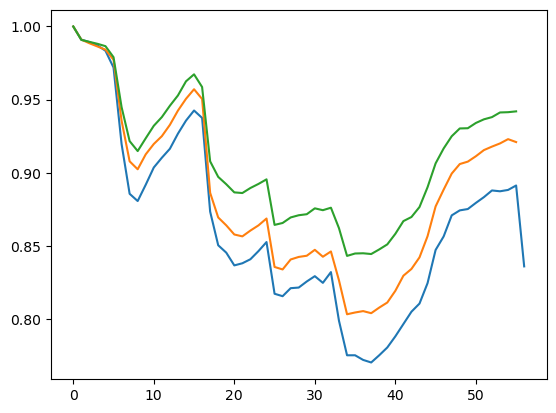

In [233]:
r = 5
plt.plot(oc_slice[r])
plt.plot(rc_slice[r])
plt.plot(gc_slice[r])

In [236]:
oc_dip0 = []
rc_dip0 = []
gc_dip0 = []
oc_invivo0 = []
rc_invivo0 = []
gc_invivo0 = []
oc_slice0 = []
rc_slice0 = []
gc_slice0 = []

In [237]:
#data_dip values - calculate alignment fraction pre-warp vs green warp vs red warp
n_cores = 30
for i in trange(len(data_dip)):
#i = 0
    refl = np.nan
    for j in range(len(os.listdir(headd+data_dip[i]+dird31g))):
        if (r'toref' in os.listdir(headd+data_dip[i]+dird31g)[j]) and (r'xydftshifts' not in os.listdir(headd+data_dip[i]+dird31g)[j]):
            refl = j
    ref_dip.append(int(os.listdir(headd+data_dip[i]+dird31g)[refl][os.listdir(headd+data_dip[i]+dird31g)[refl].find(r'toref')+5:-4]))
    
    pmo = np.load(headp+data_dip[i]+tailp31o,mmap_mode='r+')
    pmr = np.load(headp+data_dip[i]+tailp31r,mmap_mode='r+')
    pmg = np.load(headp+data_dip[i]+tailp31g,mmap_mode='r+')
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmo[0,...]*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))
    
    pmocto0c0 = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmr[0,...]*(pmr[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmr.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmr[k,...]*(pmr[k,...]>0)*(pmr[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmr.shape[0]))
    
    pmrcto0c0 = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))
    
    pmgcto0c0 = np.asarray(results)
    del results
    
    oc_dip0.append(pmocto0c0.flatten())
    rc_dip0.append(pmrcto0c0.flatten())
    gc_dip0.append(pmgcto0c0.flatten())

  0%|          | 0/53 [00:00<?, ?it/s]


Correlating...: 100%|██████████████████████████| 36/36 [00:16<00:00,  2.20it/s]

Correlating...: 100%|██████████████████████████| 36/36 [00:15<00:00,  2.38it/s]

Correlating...: 100%|██████████████████████████| 36/36 [00:15<00:00,  2.32it/s]

Correlating...: 100%|██████████████████████████| 30/30 [00:13<00:00,  2.14it/s]

Correlating...: 100%|██████████████████████████| 30/30 [00:13<00:00,  2.16it/s]

Correlating...: 100%|██████████████████████████| 30/30 [00:14<00:00,  2.11it/s]

Correlating...: 100%|██████████████████████████| 63/63 [00:28<00:00,  2.21it/s]

Correlating...: 100%|██████████████████████████| 63/63 [00:29<00:00,  2.14it/s]

Correlating...: 100%|██████████████████████████| 63/63 [00:28<00:00,  2.22it/s]

Correlating...: 100%|██████████████████████████| 51/51 [00:22<00:00,  2.23it/s]

Correlating...: 100%|██████████████████████████| 51/51 [00:22<00:00,  2.28it/s]

Correlating...: 100%|██████████████████████████| 51/51 [00:22<00:00,  2.28it/s]

Correlating...: 100%|██████

In [238]:
#data_invivo values - calculate alignment fraction pre-warp vs green warp vs red warp
n_cores = 30
for i in trange(len(data_invivo)):
#i = 0
    refl = np.nan
    for j in range(len(os.listdir(headd+data_invivo[i]+dird52g))):
        if (r'toref' in os.listdir(headd+data_invivo[i]+dird52g)[j]) and (r'xydftshifts' not in os.listdir(headd+data_invivo[i]+dird52g)[j]):
            refl = j
    ref_dip.append(int(os.listdir(headd+data_invivo[i]+dird52g)[refl][os.listdir(headd+data_invivo[i]+dird52g)[refl].find(r'toref')+5:-4]))
    
    pmo = np.load(headp+data_invivo[i]+tailp52o,mmap_mode='r+')
    pmr = np.load(headp+data_invivo[i]+tailp52r,mmap_mode='r+')
    pmg = np.load(headp+data_invivo[i]+tailp52g,mmap_mode='r+')
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmo[0,...]*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))
    
    pmocto0c0 = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmr[0,...]*(pmr[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmr.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmr[k,...]*(pmr[k,...]>0)*(pmr[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmr.shape[0]))
    
    pmrcto0c0 = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))
    
    pmgcto0c0 = np.asarray(results)
    del results
    
    oc_invivo0.append(pmocto0c0.flatten())
    rc_invivo0.append(pmrcto0c0.flatten())
    gc_invivo0.append(pmgcto0c0.flatten())

  0%|          | 0/14 [00:00<?, ?it/s]


Correlating...: 100%|████████████████████████| 143/143 [01:00<00:00,  2.38it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:02<00:00,  2.27it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:05<00:00,  2.16it/s]

Correlating...: 100%|████████████████████████| 143/143 [01:05<00:00,  2.19it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:03<00:00,  2.23it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:05<00:00,  2.18it/s]

Correlating...: 100%|████████████████████████| 170/170 [01:14<00:00,  2.28it/s]

Correlating...: 100%|████████████████████████| 169/169 [01:12<00:00,  2.32it/s]

Correlating...: 100%|████████████████████████| 169/169 [01:15<00:00,  2.25it/s]

Correlating...: 100%|████████████████████████| 143/143 [01:01<00:00,  2.34it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:03<00:00,  2.22it/s]

Correlating...: 100%|████████████████████████| 142/142 [01:04<00:00,  2.19it/s]

Correlating...: 100%|██████

In [239]:
#data_slice values - calculate alignment fraction pre-warp vs green warp vs red warp
n_cores = 30
for i in trange(len(data_slice)):
#i = 0
    refl = np.nan
    for j in range(len(os.listdir(headd+data_slice[i]+dird52g))):
        if (r'toref' in os.listdir(headd+data_slice[i]+dird52g)[j]) and (r'xydftshifts' not in os.listdir(headd+data_slice[i]+dird52g)[j]):
            refl = j
    ref_dip.append(int(os.listdir(headd+data_slice[i]+dird52g)[refl][os.listdir(headd+data_slice[i]+dird52g)[refl].find(r'toref')+5:-4]))
    
    pmo = np.load(headp+data_slice[i]+tailp52o,mmap_mode='r+')
    pmr = np.load(headp+data_slice[i]+tailp52r,mmap_mode='r+')
    pmg = np.load(headp+data_slice[i]+tailp52g,mmap_mode='r+')
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmo[0,...]*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))
    
    pmocto0c0 = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmr[0,...]*(pmr[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmr.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmr[k,...]*(pmr[k,...]>0)*(pmr[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmr.shape[0]))
    
    pmrcto0c0 = np.asarray(results)
    del results
    
    #%%time
    #n_cores = 30
    ay = st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
    with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))
    
    pmgcto0c0 = np.asarray(results)
    del results
    
    oc_slice0.append(pmocto0c0.flatten())
    rc_slice0.append(pmrcto0c0.flatten())
    gc_slice0.append(pmgcto0c0.flatten())

  0%|          | 0/11 [00:00<?, ?it/s]


Correlating...: 100%|██████████████████████████| 57/57 [00:28<00:00,  1.99it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.26it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.31it/s]

Correlating...: 100%|██████████████████████████| 57/57 [00:24<00:00,  2.33it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.29it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.31it/s]

Correlating...: 100%|██████████████████████████| 57/57 [00:24<00:00,  2.28it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.25it/s]

Correlating...: 100%|██████████████████████████| 56/56 [00:24<00:00,  2.27it/s]

Correlating...: 100%|██████████████████████████| 54/54 [00:23<00:00,  2.31it/s]

Correlating...: 100%|██████████████████████████| 53/53 [00:22<00:00,  2.31it/s]

Correlating...: 100%|██████████████████████████| 53/53 [00:23<00:00,  2.26it/s]

Correlating...: 100%|██████

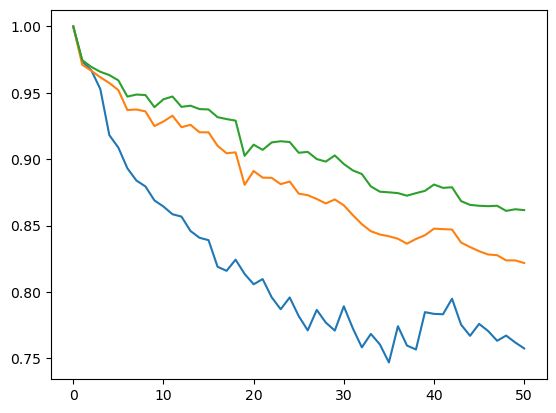

In [240]:
r = 45
plt.plot(oc_dip0[r])
plt.plot(rc_dip0[r])
plt.plot(gc_dip0[r])

\in_vivo\231105_DG39PL32\mouse
282.795


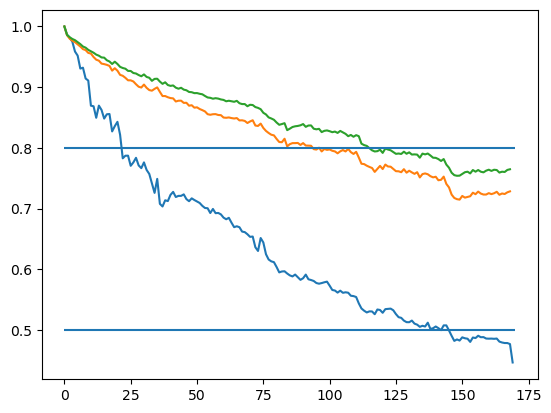

In [57]:
r = 9
print(data_invivo[r])
print(len(oc_invivo0[r])*timefac52/60)
plt.plot(oc_invivo0[r])
plt.plot(rc_invivo0[r])
plt.plot(gc_invivo0[r])
plt.hlines(y=0.8,xmin=0,xmax=len(oc_invivo0[r]))
plt.hlines(y=0.5,xmin=0,xmax=len(oc_invivo0[r]))

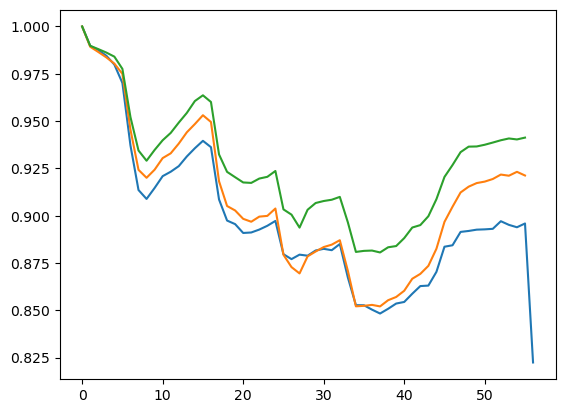

In [242]:
r = 5
plt.plot(oc_slice0[r])
plt.plot(rc_slice0[r])
plt.plot(gc_slice0[r])

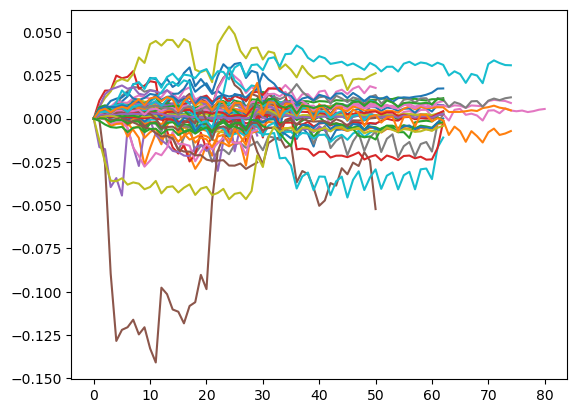

In [259]:
for r in range(len(gc_dip)):
    plt.plot(gc_dip[r]-gc_dip0[r])

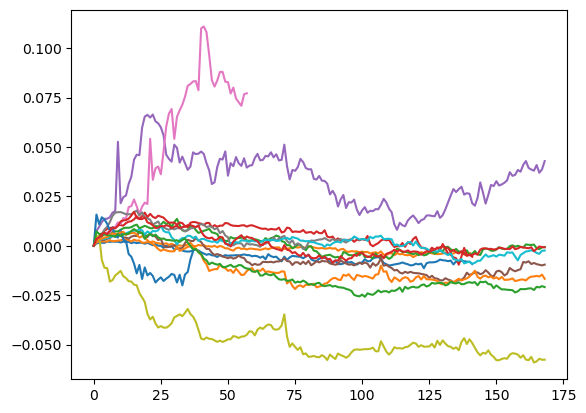

In [260]:
for r in range(len(gc_invivo)):
    plt.plot(gc_invivo[r]-gc_invivo0[r])

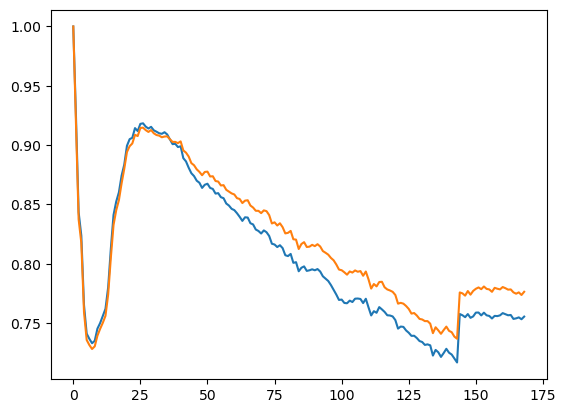

In [269]:
r = 12
plt.plot(gc_invivo[r])
plt.plot(gc_invivo0[r])

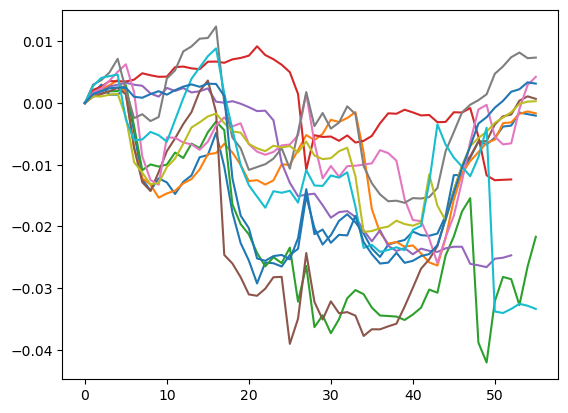

In [262]:
for r in range(len(gc_slice)):
    plt.plot(gc_slice[r]-gc_slice0[r])

In [273]:
%%time
basedir = r'\\nasquatch\data\2p\peter\grin_videos\s12_outputs'

with open(basedir+r'\oc_dip.pickle', 'wb') as f:
    pickle.dump(oc_dip, f)
with open(basedir+r'\rc_dip.pickle', 'wb') as f:
    pickle.dump(rc_dip, f)
with open(basedir+r'\gc_dip.pickle', 'wb') as f:
    pickle.dump(gc_dip, f)
with open(basedir+r'\oc_invivo.pickle', 'wb') as f:
    pickle.dump(oc_invivo, f)
with open(basedir+r'\rc_invivo.pickle', 'wb') as f:
    pickle.dump(rc_invivo, f)
with open(basedir+r'\gc_invivo.pickle', 'wb') as f:
    pickle.dump(gc_invivo, f)
with open(basedir+r'\oc_slice.pickle', 'wb') as f:
    pickle.dump(oc_slice, f)
with open(basedir+r'\rc_slice.pickle', 'wb') as f:
    pickle.dump(rc_slice, f)
with open(basedir+r'\gc_slice.pickle', 'wb') as f:
    pickle.dump(gc_slice, f)
    
with open(basedir+r'\oc_dip0.pickle', 'wb') as f:
    pickle.dump(oc_dip0, f)
with open(basedir+r'\rc_dip0.pickle', 'wb') as f:
    pickle.dump(rc_dip0, f)
with open(basedir+r'\gc_dip0.pickle', 'wb') as f:
    pickle.dump(gc_dip0, f)
with open(basedir+r'\oc_invivo0.pickle', 'wb') as f:
    pickle.dump(oc_invivo0, f)
with open(basedir+r'\rc_invivo0.pickle', 'wb') as f:
    pickle.dump(rc_invivo0, f)
with open(basedir+r'\gc_invivo0.pickle', 'wb') as f:
    pickle.dump(gc_invivo0, f)
with open(basedir+r'\oc_slice0.pickle', 'wb') as f:
    pickle.dump(oc_slice0, f)
with open(basedir+r'\rc_slice0.pickle', 'wb') as f:
    pickle.dump(rc_slice0, f)
with open(basedir+r'\gc_slice0.pickle', 'wb') as f:
    pickle.dump(gc_slice0, f)

CPU times: total: 31.2 ms
Wall time: 99 ms


In [7]:
basedir = r'\\nasquatch\data\2p\peter\grin_videos\s12_outputs'
basedir+r'\oc_dip.npy'

'\\\\nasquatch\\data\\2p\\peter\\grin_videos\\s12_outputs\\oc_dip.npy'

In [8]:
oc_invivo0 = load_pickle(basedir+r'\oc_invivo0.pickle')
rc_invivo0 = load_pickle(basedir+r'\rc_invivo0.pickle')
gc_invivo0 = load_pickle(basedir+r'\gc_invivo0.pickle')

In [ ]:
pmo = np.load(headp+data_dip[i]+tailp31o,mmap_mode='r+')
pmr = np.load(headp+data_dip[i]+tailp31r,mmap_mode='r+')
pmg = np.load(headp+data_dip[i]+tailp31g,mmap_mode='r+')

In [167]:
#%%time
#n_cores = 30
ay = st.rescale(pmo[0,...]*(pmo[0,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))

pmocto0cref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:14<00:00,  2.54it/s]

CPU times: total: 10.2 s
Wall time: 14.4 s


In [168]:
#%%time
#n_cores = 30
ay = st.rescale(pmr[0,...]*(pmr[0,...]>0)*(pmr[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmr.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmr[k,...]*(pmr[k,...]>0)*(pmr[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmr.shape[0]))

pmrcto0cref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:12<00:00,  2.80it/s]

CPU times: total: 10.4 s
Wall time: 13.1 s


In [169]:
#%%time
#n_cores = 30
ay = st.rescale(pmg[0,...]*(pmg[0,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))

pmgcto0cref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:13<00:00,  2.75it/s]

CPU times: total: 10.5 s
Wall time: 13.4 s


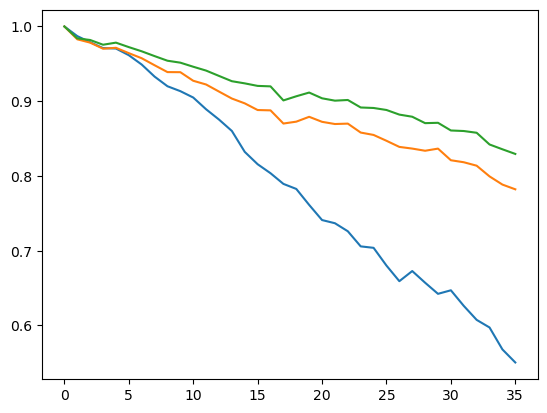

In [170]:
plt.plot(pmocto0cref.flatten())
plt.plot(pmrcto0cref.flatten())
plt.plot(pmgcto0cref.flatten())

(36, 1, 1, 1)

In [55]:
pmo = np.load(headp+data_dip[i]+tailp31o,mmap_mode='r+')
print(pmo.shape)

(36, 30, 450, 510)


In [56]:
%%time
pmojto0 = np.zeros(pmo.shape[0])
ja = pmo[0,...].flatten()>0
for j in trange(pmo.shape[0]):
    jb = pmo[j,...].flatten()>0
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmojto0[j] = np.sum(ja*jb)/np.min([np.sum(ja>0),np.sum(jb>0)])

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.28 s
Wall time: 2.29 s


In [57]:
%%time
pmojtoref = np.zeros(pmo.shape[0])
ja = pmo[ref_dip[i],...].flatten()>0
for j in trange(pmo.shape[0]):
    jb = pmo[j,...].flatten()>0
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmojtoref[j] = np.sum(ja*jb)/np.min([np.sum(ja>0),np.sum(jb>0)])

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.12 s
Wall time: 2.1 s


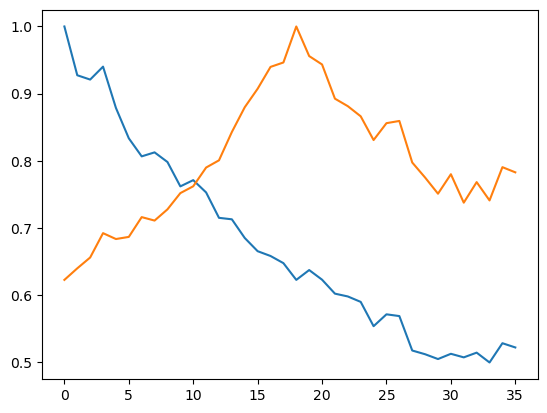

In [58]:
plt.plot(pmojto0)
plt.plot(pmojtoref)

In [59]:
pmr = np.load(headp+data_dip[i]+tailp31r,mmap_mode='r+')
print(pmr.shape)

(36, 30, 450, 507)


In [60]:
%%time
pmrjto0 = np.zeros(pmr.shape[0])
ja = pmr[0,...].flatten()>0
for j in trange(pmr.shape[0]):
    jb = pmr[j,...].flatten()>0
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmrjto0[j] = np.sum(ja*jb)/np.min([np.sum(ja>0),np.sum(jb>0)])

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.27 s
Wall time: 2.25 s


In [61]:
%%time
pmrjtoref = np.zeros(pmr.shape[0])
ja = pmr[ref_dip[i],...].flatten()>0
for j in trange(pmr.shape[0]):
    jb = pmr[j,...].flatten()>0
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmrjtoref[j] = np.sum(ja*jb)/np.min([np.sum(ja>0),np.sum(jb>0)])

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.2 s
Wall time: 2.2 s


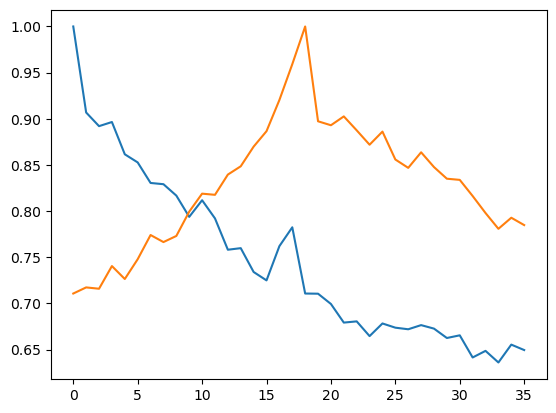

In [62]:
plt.plot(pmrjto0)
plt.plot(pmrjtoref)

In [63]:
pmg = np.load(headp+data_dip[i]+tailp31g,mmap_mode='r+')
print(pmg.shape)

(36, 30, 450, 507)


In [64]:
%%time
pmgjto0 = np.zeros(pmg.shape[0])
ja = pmg[0,...].flatten()>0
for j in trange(pmg.shape[0]):
    jb = pmg[j,...].flatten()>0
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmgjto0[j] = np.sum(ja*jb)/np.min([np.sum(ja>0),np.sum(jb>0)])

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.25 s
Wall time: 2.23 s


In [65]:
%%time
pmgjtoref = np.zeros(pmg.shape[0])
ja = pmg[ref_dip[i],...].flatten()>0
for j in trange(pmg.shape[0]):
    jb = pmg[j,...].flatten()>0
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmgjtoref[j] = np.sum(ja*jb)/np.min([np.sum(ja>0),np.sum(jb>0)])

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.05 s
Wall time: 2.04 s


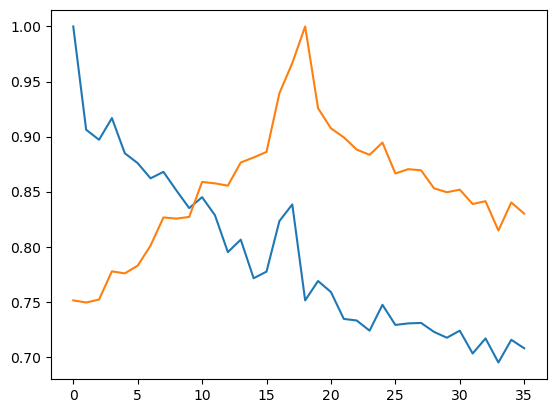

In [66]:
plt.plot(pmgjto0)
plt.plot(pmgjtoref)

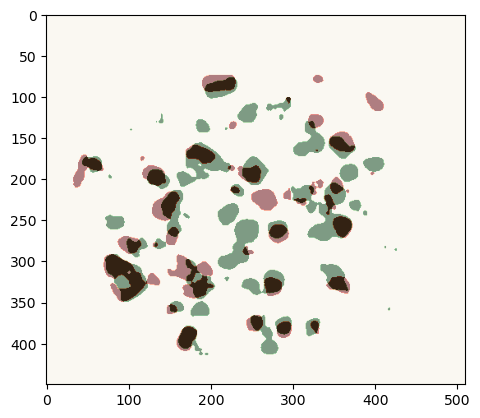

In [30]:
plt.imshow(pmo[30,15,...]>0,cmap='Greens')
plt.imshow(pmo[0,15,...]>0, cmap='Reds', alpha=0.5)

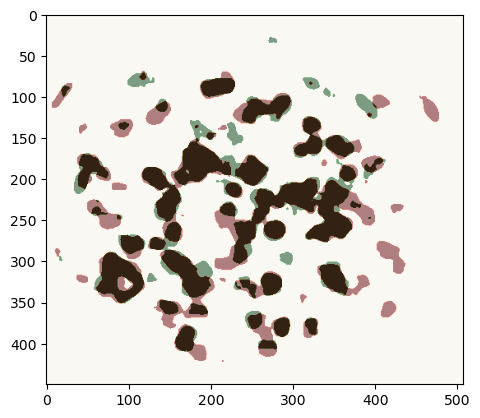

In [80]:
plt.imshow(pmg[0,15,...]>0,cmap='Greens')
plt.imshow(pmg[30,15,...]>0, cmap='Reds', alpha=0.5)

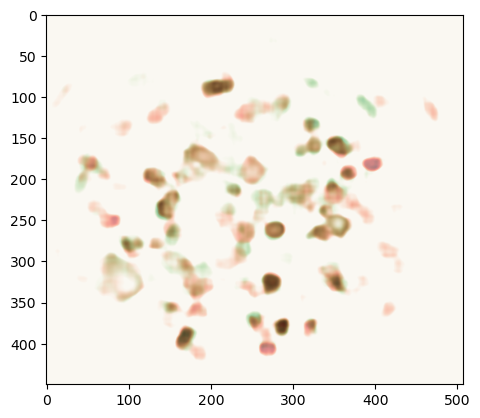

In [79]:
plt.imshow(pmg[0,15,...]*(pmg[0,15,...]>0),cmap='Greens')
plt.imshow(pmg[30,15,...]*(pmg[30,15,...]>0), cmap='Reds', alpha=0.5)

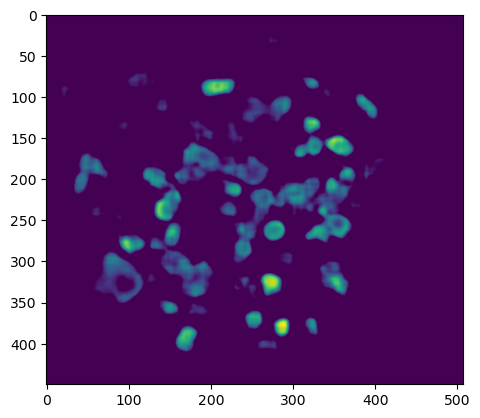

In [81]:
plt.imshow(pmg[0,15,...]*(pmg[0,15,...]>0))

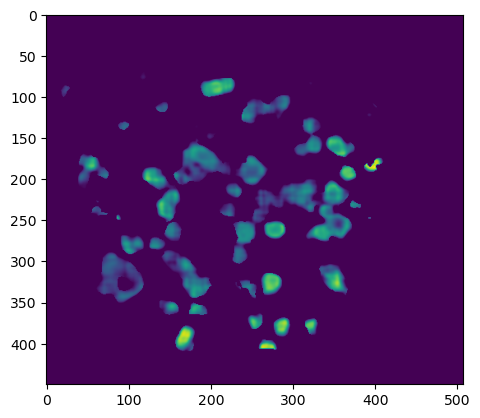

In [112]:
plt.imshow(pmg[30,15,...]*(pmg[30,15,...]>0)*(pmg[0,15,...]>0))

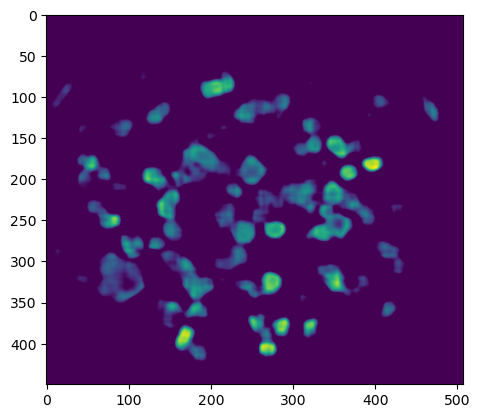

In [82]:
plt.imshow(pmg[30,15,...]*(pmg[30,15,...]>0))

In [44]:
%%time
n_cores = 30
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(st.rescale(pmg[ref_dip[i],...]*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)>0,st.rescale(pmg[k,...]*(pmg[k,...]>0),(1,1/4,1/4),anti_aliasing=True)>0) for k in range(pmg.shape[0]))

pmgctoref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:31<00:00,  1.14it/s]

CPU times: total: 18.5 s
Wall time: 31.7 s


In [45]:
%%time
n_cores = 30
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(st.rescale(pmg[ref_dip[i],...]*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True),st.rescale(pmg[k,...]*(pmg[k,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))

pmgctorefc = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:19<00:00,  1.85it/s]

CPU times: total: 17.2 s
Wall time: 19.4 s


In [131]:
%%time
n_cores = 30
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)>0,st.rescale(pmg[k,...]*(pmg[k,...]>0),(1,1/4,1/4),anti_aliasing=True)>0) for k in range(pmg.shape[0]))

pmgcto0 = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:24<00:00,  1.45it/s]

CPU times: total: 19.1 s
Wall time: 24.8 s


In [131]:
%%time
n_cores = 30
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True),st.rescale(pmg[k,...]*(pmg[k,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))

pmgcto0c = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:24<00:00,  1.45it/s]

CPU times: total: 19.1 s
Wall time: 24.8 s


In [133]:
%%time
n_cores = 30
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(st.rescale(pmo[0,...]*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)>0,st.rescale(pmo[k,...]*(pmo[k,...]>0),(1,1/4,1/4),anti_aliasing=True)>0) for k in range(pmo.shape[0]))

pmocto0 = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:23<00:00,  1.53it/s]

CPU times: total: 18.5 s
Wall time: 23.5 s


In [68]:
%%time
n_cores = 30
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(st.rescale(pmo[0,...]*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True),st.rescale(pmo[k,...]*(pmo[k,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))

pmocto0c = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:19<00:00,  1.82it/s]

CPU times: total: 17.4 s
Wall time: 19.7 s


In [77]:
ay = st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
print(np.mean(ay[ay>0]))
print(np.max(ay))
print(np.sum(ay))

3.0956185
37.36332
236585.72


In [78]:
ay = st.rescale(pmg[30,...]*(pmg[30,...]>0),(1,1/4,1/4),anti_aliasing=True)
print(np.mean(ay[ay>0]))
print(np.max(ay))
print(np.sum(ay))

3.290668
31.07895
263381.78


In [103]:
%%time
n_cores = 30
ay = st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))

pmgcto0c0 = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:13<00:00,  2.61it/s]

CPU times: total: 10 s
Wall time: 14 s


In [104]:
%%time
n_cores = 30
ay = st.rescale(pmo[0,...]*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))

pmocto0c0 = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:12<00:00,  2.84it/s]

CPU times: total: 10.4 s
Wall time: 12.9 s


In [108]:
%%time
n_cores = 30
ay = st.rescale(pmg[0,...]*(pmg[0,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))

pmgcto0cref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:13<00:00,  2.70it/s]

CPU times: total: 10.9 s
Wall time: 13.6 s


In [109]:
%%time
n_cores = 30
ay = st.rescale(pmo[0,...]*(pmo[0,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))

pmocto0cref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:13<00:00,  2.62it/s]

CPU times: total: 11.2 s
Wall time: 14 s


In [162]:
%%time
n_cores = 30
ay = st.rescale(pmg[ref_dip[i],...]*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmg.shape[0]))

pmgctorefcref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:13<00:00,  2.62it/s]

CPU times: total: 10.2 s
Wall time: 14 s


In [163]:
%%time
n_cores = 30
ay = st.rescale(pmo[ref_dip[i],...]*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)
with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)) for k in range(pmo.shape[0]))

pmoctorefcref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:12<00:00,  2.89it/s]

CPU times: total: 9.67 s
Wall time: 12.7 s


In [126]:
%%time
n_cores = 30
ay = st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)>0
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True)>0) for k in range(pmg.shape[0]))

pmgcto00 = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:19<00:00,  1.88it/s]

CPU times: total: 10.2 s
Wall time: 19.4 s


In [127]:
%%time
n_cores = 30
ay = st.rescale(pmo[0,...]*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)>0
with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True)>0) for k in range(pmo.shape[0]))

pmocto00 = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:17<00:00,  2.07it/s]

CPU times: total: 11 s
Wall time: 17.7 s


In [128]:
%%time
n_cores = 30
ay = st.rescale(pmg[0,...]*(pmg[0,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)>0
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0)*(pmg[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)>0) for k in range(pmg.shape[0]))

pmgcto0ref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:18<00:00,  2.00it/s]

CPU times: total: 10.6 s
Wall time: 18.4 s


In [129]:
%%time
n_cores = 30
ay = st.rescale(pmo[0,...]*(pmo[0,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)>0
with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(sf.match_template)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0)*(pmo[ref_dip[i],...]>0),(1,1/4,1/4),anti_aliasing=True)>0) for k in range(pmo.shape[0]))

pmocto0ref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:17<00:00,  2.10it/s]

CPU times: total: 10.2 s
Wall time: 17.4 s


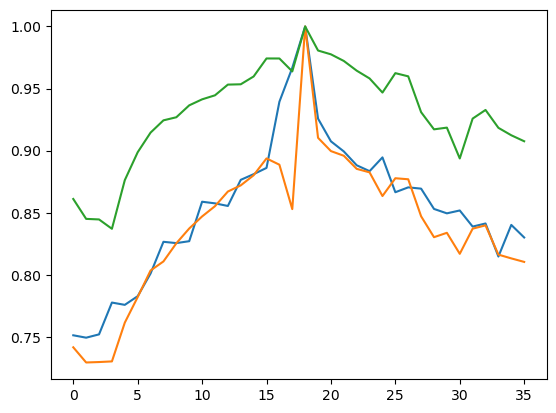

In [47]:
plt.plot(pmgjtoref)
plt.plot(pmgctoref.flatten())
plt.plot(pmgctorefc.flatten())

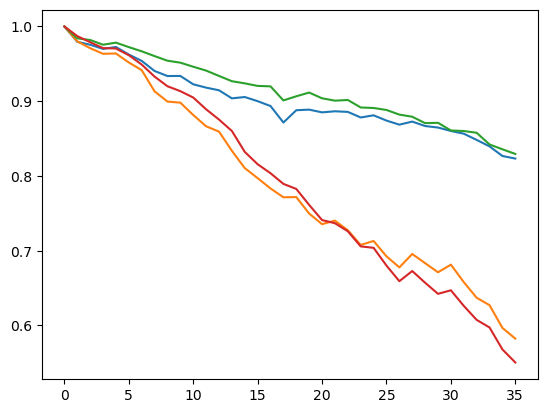

In [111]:
#plt.plot(pmgcto0c.flatten())
#plt.plot(pmocto0c.flatten())
plt.plot(pmgcto0c0.flatten())
plt.plot(pmocto0c0.flatten())
plt.plot(pmgcto0cref.flatten())
plt.plot(pmocto0cref.flatten())

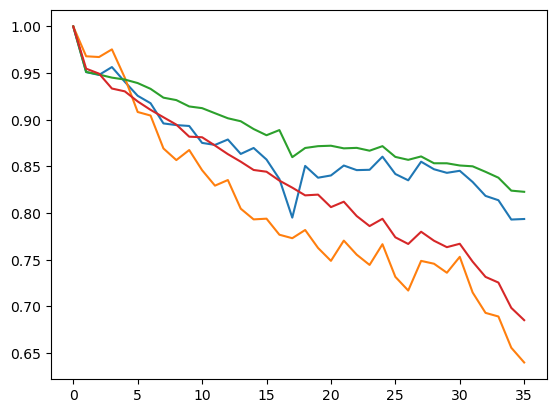

In [135]:
#plt.plot(pmgcto0.flatten())
#plt.plot(pmocto0.flatten())
plt.plot(pmgcto00.flatten())
plt.plot(pmocto00.flatten())
plt.plot(pmgcto0ref.flatten())
plt.plot(pmocto0ref.flatten())

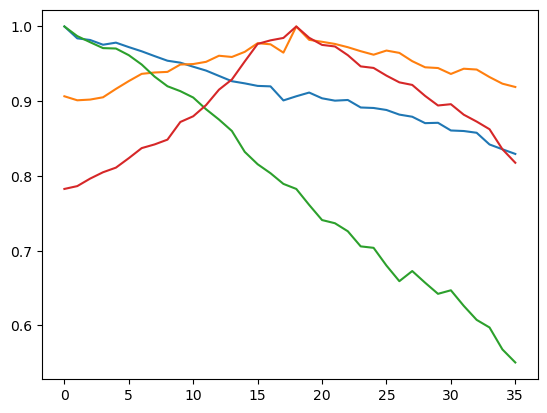

In [164]:
plt.plot(pmgcto0cref.flatten())
plt.plot(pmgctorefcref.flatten())
plt.plot(pmocto0cref.flatten())
plt.plot(pmoctorefcref.flatten())

In [141]:
(pmg[ref_dip[i],...].flatten()>0).shape

(6844500,)

In [142]:
(pmg[ref_dip[i],...].flatten()).shape

(6844500,)

In [143]:
st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True).flatten().shape

(426720,)

In [144]:
st.rescale(pmg[ref_dip[i],...],(1,1/4,1/4),anti_aliasing=True).flatten().shape

(426720,)

In [145]:
st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True).flatten()[st.rescale(pmg[ref_dip[i],...],(1,1/4,1/4),anti_aliasing=True).flatten()>0].shape

(28220,)

In [156]:
%%time
n_cores = 30
rr = st.rescale(pmg[ref_dip[i],...],(1,1/4,1/4),anti_aliasing=True).flatten()
ay = st.rescale(pmg[0,...]*(pmg[0,...]>0),(1,1/4,1/4),anti_aliasing=True).flatten()[rr>0]
with tqdm_joblib(tqdm(desc="Correlating...", total=pmg.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(ss.spearmanr)(ay,st.rescale(pmg[k,...]*(pmg[k,...]>0),(1,1/4,1/4),anti_aliasing=True).flatten()[rr>0]) for k in range(pmg.shape[0]))

pmgcto0sref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:08<00:00,  4.37it/s]

CPU times: total: 8.7 s
Wall time: 8.68 s


In [157]:
%%time
n_cores = 30
rr = st.rescale(pmo[ref_dip[i],...],(1,1/4,1/4),anti_aliasing=True).flatten()
ay = st.rescale(pmo[0,...]*(pmo[0,...]>0),(1,1/4,1/4),anti_aliasing=True).flatten()[rr>0]
with tqdm_joblib(tqdm(desc="Correlating...", total=pmo.shape[0])) as progress_bar:
    results = Parallel(n_jobs=n_cores)(delayed(ss.spearmanr)(ay,st.rescale(pmo[k,...]*(pmo[k,...]>0),(1,1/4,1/4),anti_aliasing=True).flatten()[rr>0]) for k in range(pmo.shape[0]))

pmocto0sref = np.asarray(results)
del results

Correlating...: 100%|██████████████████████████| 36/36 [00:08<00:00,  4.46it/s]

CPU times: total: 8.52 s
Wall time: 8.5 s


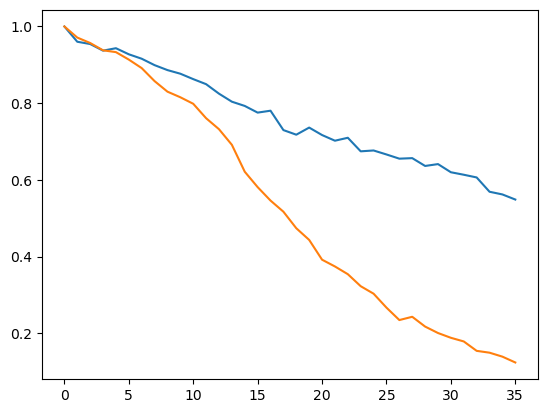

In [159]:
plt.plot(pmgcto0sref[:,0])
plt.plot(pmocto0sref[:,0])

In [123]:
%%time
pmgjto00 = np.zeros(pmg.shape[0])
ja = pmg[0,...].flatten()>0
for j in trange(pmg.shape[0]):
    jb = (pmg[j,...].flatten()>0)*(pmg[0,...].flatten()>0)
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmgjto00[j] = np.sum(ja*jb)/np.sum(ja>0)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.92 s
Wall time: 2.91 s


In [119]:
%%time
pmgjto0ref = np.zeros(pmg.shape[0])
ja = (pmg[0,...].flatten()>0)*(pmg[ref_dip[i],...].flatten()>0)
for j in trange(pmg.shape[0]):
    jb = (pmg[j,...].flatten()>0)*(pmg[ref_dip[i],...].flatten()>0)
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmgjto0ref[j] = np.sum(ja*jb)/np.sum(ja>0)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.44 s
Wall time: 2.43 s


In [124]:
%%time
pmojto00 = np.zeros(pmo.shape[0])
ja = (pmo[0,...].flatten()>0)
for j in trange(pmo.shape[0]):
    jb = (pmo[j,...].flatten()>0)*(pmo[0,...].flatten()>0)
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmojto00[j] = np.sum(ja*jb)/np.sum(ja>0)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.89 s
Wall time: 2.89 s


In [121]:
%%time
pmojto0ref = np.zeros(pmo.shape[0])
ja = (pmo[0,...].flatten()>0)*(pmo[ref_dip[i],...].flatten()>0)
for j in trange(pmo.shape[0]):
    jb = (pmo[j,...].flatten()>0)*(pmo[ref_dip[i],...].flatten()>0)
    #Yzbjto0[i] = np.sum(ja*jb)/(2*np.min([np.sum(ja>0),np.sum(jb>0)])-np.sum(ja*jb))
    pmojto0ref[j] = np.sum(ja*jb)/np.sum(ja>0)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: total: 2.42 s
Wall time: 2.42 s


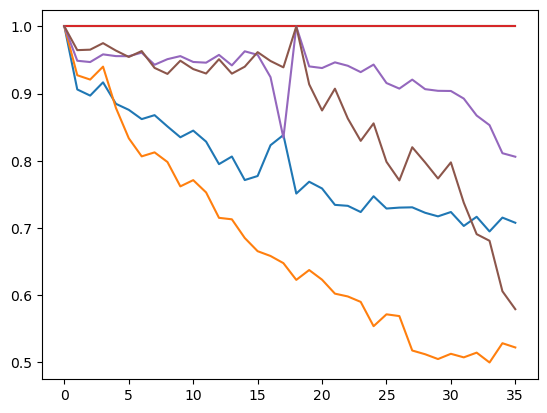

In [125]:
plt.plot(pmgjto0)
plt.plot(pmojto0)
plt.plot(pmgjto00)
plt.plot(pmojto00)
plt.plot(pmgjto0ref)
plt.plot(pmojto0ref)

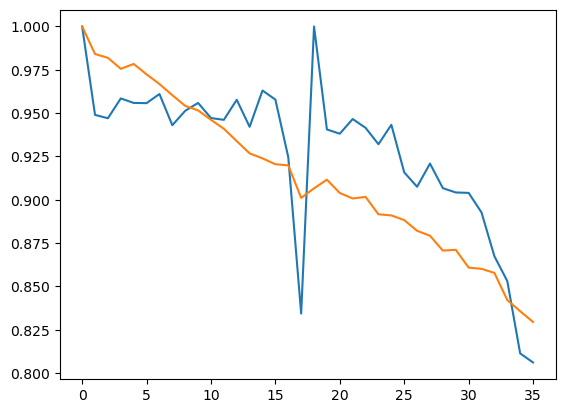

In [161]:
plt.plot(pmgjto0ref)
plt.plot(pmgcto0cref.flatten())